In [1]:
import sys
sys.path.append('/home/greg/GitHub/')
import pyEDIutils.changes as edi
import pyEDIutils.audit_rpts as edia
import pandas as pd
import numpy as np
import datetime as dt

In [2]:
# Set some parameters
start_rpt = '2022-12-01'
end_rpt = '2023-11-02'
annrpt_year = '2023'

## Archive a request for earlier data

Do this if needed to update the request archives to create a full year dataset for the current report .

In [3]:
# Only do this if it isn't archived yet!
edi.archive_requested_changes('2023-06-02', '2023-11-02')

Requesting PASTA changes for knb-lter-jrn from 2023-06-02 to 2023-11-02
https://pasta.lternet.edu/package/changes/eml?fromDate=2023-06-02&toDate=2023-11-02&scope=knb-lter-jrn
Archiving request at ./edi_requests/knb-lter-jrn_20230602-20231102.xml


## Load archived requests and most recent data

In [3]:
archived = edi.load_archived_changes()

Reading archived PASTA request knb-lter-jrn_20150417-20181231.xml
Reading archived PASTA request knb-lter-jrn_20190101-20191231.xml
Reading archived PASTA request knb-lter-jrn_20200101-20200601.xml
Reading archived PASTA request knb-lter-jrn_20200602-20201201.xml
Reading archived PASTA request knb-lter-jrn_20201202-20210601.xml
Reading archived PASTA request knb-lter-jrn_20210602-20220101.xml
Reading archived PASTA request knb-lter-jrn_20220102-20220531.xml
Reading archived PASTA request knb-lter-jrn_20220601-20221101.xml
Reading archived PASTA request knb-lter-jrn_20221102-20230315.xml
Reading archived PASTA request knb-lter-jrn_20230316-20230601.xml
Reading archived PASTA request knb-lter-jrn_20230602-20231102.xml
9 duplicate records were removed.


In [4]:
# Find the last PASTA entry in the archive and convert to datetime
last_archived = pd.to_datetime(archived.date.iloc[-1])

In [31]:
# If the last_archived  value is less than report endtime, get the most recent
# changes (default is retrieve to today) and concatenate to archived requests
if last_archived < pd.to_datetime(end_rpt):
    last_archived_plus1d = last_archived.date() + pd.DateOffset(1)
    # Request changes from last archive to enddate
    new = edi.request_changes(last_archived_plus1d.isoformat())
    if new.empty:
        df = archived.copy()
    else:
        # Concat
        df = pd.concat([archived, new])
else:
    df = archived.copy()
    

Requesting PASTA changes for knb-lter-jrn from 2023-10-18T00:00:00 to None
https://pasta.lternet.edu/package/changes/eml?fromDate=2023-10-18T00%3A00%3A00&toDate=2023-11-03&scope=knb-lter-jrn
0 duplicate records were removed.


In [32]:
# Now create datetime index and subset dataframe
df.index = pd.to_datetime(df['date'])
df = df.loc[start_rpt:end_rpt]

In [33]:
# Convert raw data to counts
df = edi.get_counts(df)
df.head()


,date,pkgid,action,n_update,n_create,n_delete,n_tot
date,,,,,,,
2022-12-02 16:15:08.713,2022-12-02T16:15:08.713,210126001,updateDataPackage,1,0,0,0
2022-12-02 16:19:43.891,2022-12-02T16:19:43.891,210548025,updateDataPackage,1,0,0,0
2022-12-02 16:37:28.030,2022-12-02T16:37:28.03,210548010,updateDataPackage,1,0,0,0
2022-12-02 16:40:31.178,2022-12-02T16:40:31.178,210548040,updateDataPackage,1,0,0,0
2022-12-02 16:53:57.557,2022-12-02T16:53:57.557,210548070,updateDataPackage,1,0,0,0


In [34]:
#Get study ids
df['studyid'] = df.pkgid.astype(str).str[-6:-3]


In [35]:
# note that this returns a dataframe with a datetime index
daily = edi.counts_to_daily(df)
daily

,n_update,n_create,n_tot
date,,,
2022-12-02,65,0,0
2022-12-03,16,0,0
2022-12-04,0,0,0
2022-12-05,11,0,0
2022-12-06,112,0,0
...,...,...,...
2023-10-13,0,0,0
2023-10-14,0,0,0
2023-10-15,0,0,0


## Plot activity for annual report


In [36]:
import matplotlib
import matplotlib.pyplot as plt
# Figure config
font = {'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

# Get a datestamp for saving figures
import datetime
now = datetime.datetime.now().strftime("%Y%m%d")

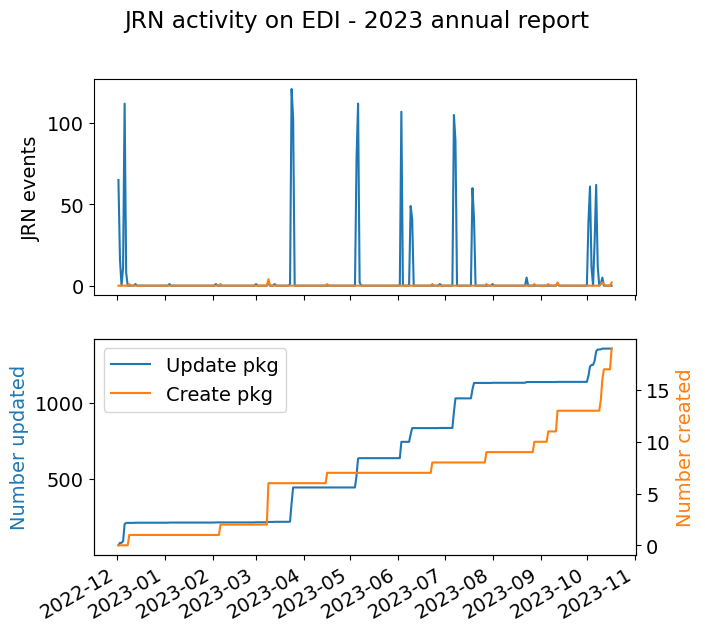

In [37]:
# All time plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update, label='Update pkg')
ax[0].plot(daily.index, daily.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily.index, daily.n_update.cumsum(), label='Update pkg')
plt.ylabel('Number updated', color='C0')
ax2 = ax[1].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create pkg', color='C1')
#ax[1].plot(daily.index, daily.n_tot.cumsum(), label='Total')

plt.ylabel('Number created', color='C1')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI - {0} annual report'.format(annrpt_year))
lines, labels = ax[1].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)
import os
fig.savefig(os.path.expanduser("~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

### Total number of packages

In [38]:
daily.n_create.sum()

19

In [39]:
daily.n_update.sum()

1354

## Plot annual activity excluding Met

In [40]:
nomet = np.logical_and(df.studyid!='437', df.studyid!='548')
daily_nomet = edi.counts_to_daily(df.loc[nomet], fromdt=start_rpt)

daily_nomet.head()

,n_update,n_create,n_tot
date,,,
2022-12-02,1,0,0
2022-12-03,0,0,0
2022-12-04,0,0,0
2022-12-05,0,0,0
2022-12-06,0,0,0


### Total number of packages

In [41]:
daily_nomet.n_create.sum()

19

In [42]:
daily_nomet.n_update.sum()

25

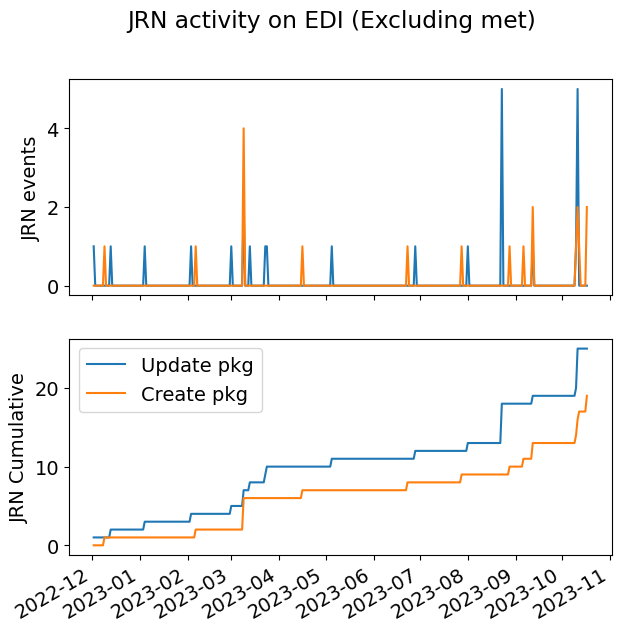

In [43]:
# Recent plot:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily_nomet.index, daily_nomet.n_update, label='Update pkg')
ax[0].plot(daily_nomet.index, daily_nomet.n_create, label='Create pkg')
ax[0].set_ylabel('JRN events')

ax[1].plot(daily_nomet.index, daily_nomet.n_update.cumsum(), label='Update pkg')
ax[1].plot(daily_nomet.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

plt.ylabel('JRN Cumulative')
fig.autofmt_xdate()
plt.suptitle('JRN activity on EDI (Excluding met)')
plt.legend()

fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt_NoMet_{1}.png".format(annrpt_year, now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Summary since last Annual Report

In [44]:
df.head()

,date,pkgid,action,n_update,n_create,n_delete,n_tot,studyid
date,,,,,,,,
2022-12-02 16:15:08.713,2022-12-02T16:15:08.713,210126001,updateDataPackage,1,0,0,0,126
2022-12-02 16:19:43.891,2022-12-02T16:19:43.891,210548025,updateDataPackage,1,0,0,0,548
2022-12-02 16:37:28.030,2022-12-02T16:37:28.03,210548010,updateDataPackage,1,0,0,0,548
2022-12-02 16:40:31.178,2022-12-02T16:40:31.178,210548040,updateDataPackage,1,0,0,0,548
2022-12-02 16:53:57.557,2022-12-02T16:53:57.557,210548070,updateDataPackage,1,0,0,0,548


In [45]:
# Unique packages updated (excluding met)
rEDI = df.copy()
rEDI_nomet = rEDI.loc[np.logical_and(rEDI.studyid!='437', rEDI.studyid!='548'),:]
print(len(rEDI.loc[rEDI.action=='updateDataPackage',]))
uniqueUp = rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
uniqueUp_nomet = rEDI_nomet.loc[rEDI_nomet.action=='updateDataPackage',].pkgid.unique()
#rEDI.loc[rEDI.action=='updateDataPackage',].pkgid.unique()
print(uniqueUp)
print(uniqueUp_nomet)
print(len(uniqueUp))
len(uniqueUp_nomet)

1354
[210126001 210548025 210548010 210548040 210548070 210548085 210548055
 210548026 210548011 210548041 210548071 210548086 210548056 210548027
 210548012 210548042 210548072 210548087 210548057 210548028 210548013
 210548043 210548073 210548088 210548058 210548029 210548014 210548044
 210548074 210548089 210548059 210548030 210548015 210548045 210548075
 210548090 210548060 210548016 210548001 210548031 210548061 210548076
 210548046 210548017 210548002 210548032 210548062 210548077 210548047
 210548018 210548003 210548033 210548063 210548078 210548048 210548019
 210548004 210548034 210548064 210548079 210548049 210548020 210548005
 210548035 210548065 210548080 210548050 210548021 210548006 210548036
 210548066 210548081 210548051 210548022 210548007 210548037 210548067
 210548082 210548052 210548023 210548008 210548068 210548083 210548053
 210548097 210548024 210548009 210548039 210548069 210548084 210548054
 210548098 210437018 210437082 210437097 210437083 210437098 210437084
 

17

In [46]:
pkgtbl = pd.DataFrame({'Total':[daily.n_create.sum(), daily.n_update.sum(),len(uniqueUp)],
                       'Non-Met':[daily_nomet.n_create.sum(), daily_nomet.n_update.sum(),len(uniqueUp_nomet)]})
pkgtbl.index = ['New packages created', 'Package updates', 'Unique package updates']

print(pkgtbl)
# Write it
with open('tables_out/{}_annrpt_edi.csv'.format(annrpt_year), 'w') as f:
    f.write(pkgtbl.to_csv())

                        Total  Non-Met
New packages created       19       19
Package updates          1354       25
Unique package updates    240       17


In [47]:
uniqueUp2 = ['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=' + str(s)
             for s in uniqueUp]
with open('tables_out/{0}AR_unique_EDI_updates_{1}.txt'.format(annrpt_year, now), 'w') as f:
    for item in uniqueUp2:
        f.write("%s\n" % item)
        
uniqueUp2


['https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210126001',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548025',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548010',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548040',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548070',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548085',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548055',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548026',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548011',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548041',
 'https://portal.edirepository.org/nis/mapbrowse?scope=knb-lter-jrn&identifier=210548071',

## Audit reporting

In [48]:
edia.request_audit(210011003)

Requesting access data for knb-lter-jrn.210011003
https://pasta.lternet.edu/audit/reads/knb-lter-jrn/210011003

    


,scope,identifier,revision,resource,total_reads,non_robot_reads
0,knb-lter-jrn,210011003,60,report,44,44
1,knb-lter-jrn,210011003,60,metadata,317,315
2,knb-lter-jrn,210011003,60,data,12,12
3,knb-lter-jrn,210011003,60,dataPackage,118,116
4,knb-lter-jrn,210011003,63,archive,2,2
5,knb-lter-jrn,210011003,63,report,66,65
6,knb-lter-jrn,210011003,63,dataPackage,231,227
7,knb-lter-jrn,210011003,63,data,21,21
8,knb-lter-jrn,210011003,63,metadata,398,393
9,knb-lter-jrn,210011003,101,data,50,50


In [49]:
# Get credentials - these could be anywhere....
import pyEDIutils.edicred as cred

In [50]:
# Get public data downloads for a scope from EDI audit report
# Sometimes this takes 2 tries
test = edia.request_audit_report('readDataEntity', cred.dn, cred.pw,
                               user='public', group=None,resid='knb-lter-jrn',
                               fromdt=start_rpt, todt=end_rpt,lim=100000)

Requesting audit report for knb-lter-jrn starting 2022-12-01
https://pasta.lternet.edu/audit/report/?category=info&service=DataPackageManager-1.0&serviceMethod=readDataEntity&user=public&authSystem=https%3A%2F%2Fpasta.edirepository.org%2Fauthentication&resourceId=knb-lter-jrn&fromTime=2022-12-01&toTime=2023-11-02&limit=100000




In [43]:
# What are the unique useragents and which should we screen out?
#test.useragent.unique()

array(['Mozilla/5.0 (Macintosh; Intel Mac OS X 10.13; rv:94.0) Gecko/20100101 Firefox/94.0',
       'Python-urllib/2.7',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:94.0) Gecko/20100101 Firefox/94.0',
       'Mozilla/5.0 (X11; Linux x86_64; rv:78.0) Gecko/20100101 Firefox/78.0',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.45 Safari/537.36',
       'curl/7.55.1',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.55 Safari/537.36 Edg/96.0.1054.43',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/12.1.2 Safari/605.1.15',
       'python-requests/2.25.1', 'python-requests/2.22.0',
       'DataONE-Python/3.4.7 +http://dataone.org/',
       'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.93 Safari/537.36',
       'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) 

In [51]:
#Exclude DataOne, curl, and python-request agents, which are most likely not 'real users'
searchfor = ['DataONE', 'python-requests', 'curl']
auto_agents = test.useragent.str.contains('|'.join(searchfor), regex=True)
print(len(test))
test_filt = test.loc[~auto_agents, :]
print(len(test_filt))

12907
6177


In [52]:
# Calculate the daily values
test_filt.index = pd.to_datetime(test_filt.entry_dt)
test_filt['n'] = 1
print('Average daily public downloads: ', test_filt.shape[0]/365)
test_filt.head()

Average daily public downloads:  16.923287671232877


/tmp/ipykernel_96402/1446458488.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filt['n'] = 1


,entry_dt,method,resource_id,user,group,useragent,n
entry_dt,,,,,,,
2022-12-01 07:10:10,2022-12-01T07:10:10,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1
2022-12-01 08:22:46,2022-12-01T08:22:46,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2022-12-01 09:14:10,2022-12-01T09:14:10,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1
2022-12-01 11:56:48,2022-12-01T11:56:48,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,1
2022-12-01 12:15:04,2022-12-01T12:15:04,readDataEntity,https://pasta.lternet.edu/package/data/eml/knb...,public,None,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,1


In [53]:
dl = test_filt.n.resample('D').count()
dl.head()

entry_dt
2022-12-01    132
2022-12-02     12
2022-12-03    109
2022-12-04      5
2022-12-05    389
Freq: D, Name: n, dtype: int64

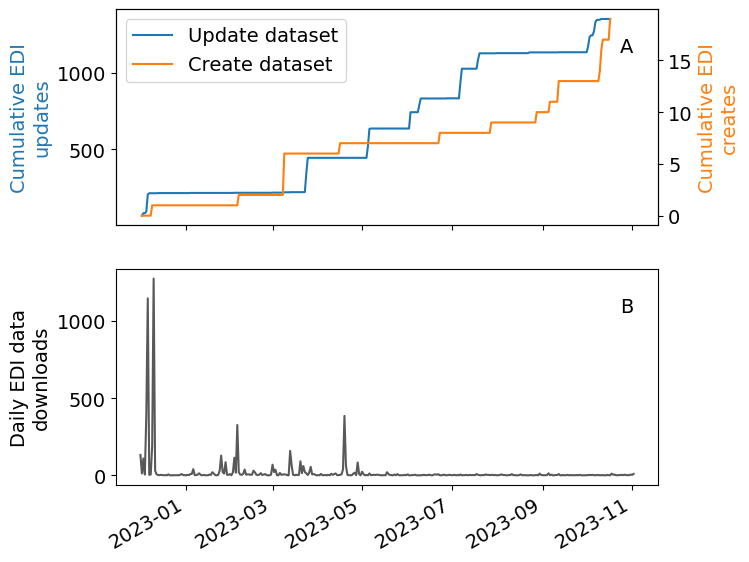

In [54]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 7), sharex=True)

ax[0].plot(daily.index, daily.n_update.cumsum(), label='Update dataset')
ax2 = ax[0].twinx()
ax2.plot(daily.index, daily.n_create.cumsum(), label='Create dataset', color='C1')
ax[0].set_ylabel('Cumulative EDI\nupdates', color='C0')
ax2.set_ylabel('Cumulative EDI\ncreates', color='C1')
ax2.text(0.93, 0.8, 'A', transform=ax2.transAxes) 
#ax[0].legend()
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)

ax[1].plot(dl, label='Download pkg', color='0.35')
#ax[1].plot(dl.index, daily_nomet.n_create.cumsum(), label='Create pkg')
#ax[1].plot(daily_nomet.index, daily_nomet.n_tot.cumsum(), label='$\Delta$ Total')
#ax[1].axhline(y=63, xmin=0, xmax=1, ls=':', lw=1.5, color='k',
#             label='Proposal goal')

ax[1].set_ylabel('Daily EDI data\ndownloads')
ax[1].text(0.93, 0.8, 'B', transform=ax[1].transAxes) 
fig.autofmt_xdate()
fig.savefig(os.path.expanduser(
    "~/GD_gmaurer@nmsu/IM/figures/JRN_EDI_{0}_ann_rpt2_{1}.png".format(annrpt_year,now)),
            dpi=150, bbox_inches='tight',facecolor='w')

## Get a list of packages updated within the date range

NOTE: this only works for the current annual report! Many packages get updated once per year at least, so they don't show up when running a previous year annual report.

The list is still available in the yearly "AR_unique_EDI_updates.csv"

If we could check prior revisions....

In [55]:
st = pd.to_datetime(start_rpt).isoformat() + 'Z'
en = pd.to_datetime(end_rpt).isoformat() + 'Z'
en

'2023-11-02T00:00:00Z'

In [56]:
import pyEDIutils.search as edis
updates = edis.search_pasta(query=['scope:knb-lter-jrn', 'pubdate:[{0} TO {1}]'.format(st, en)],
                  fields=('packageid','title','pubdate','keyword','author','begindate','enddate','doi'),
                  sortby='packageid,desc')
updates.to_csv('tables_out/{0}_PASTA_updates_solrsearch_{1}.csv'.format(annrpt_year, now))
updates

https://pasta.lternet.edu/package/search/eml?defType=edismax&q=%2A&fq=scope%3Aknb-lter-jrn&fq=pubdate%3A%5B2022-12-01T00%3A00%3A00Z+TO+2023-11-02T00%3A00%3A00Z%5D&fl=packageid%2Ctitle%2Cpubdate%2Ckeyword%2Cauthor%2Cbegindate%2Cenddate%2Cdoi&sort=packageid%2Cdesc&rows=500


,packageid,title,pubdate,keywords,authors,begindate,enddate,doi
0,knb-lter-jrn.210586002.3,Dataset and analyses for publication entitled:...,2023,inorganic nutrients;organic matter;grasslands;...,"Currier, Courtney;Reichmann, Lara;Sala, Osvaldo E",1876-01-01,2021-12-31,doi:10.6073/pasta/f2c47d19074337832ee4e720e2a0...
1,knb-lter-jrn.210586001.3,Soil and foliar carbon and nitrogen content an...,2023,inorganic nutrients;organic matter;grasslands;...,"Currier, Courtney;Reichmann, Lara;Sala, Osvaldo E",2011-06-01,2020-09-30,doi:10.6073/pasta/8929d93801db656ae1ad0f3a12a1...
2,knb-lter-jrn.210548103.28,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/029c896133cb4571259ffe077822...
3,knb-lter-jrn.210548102.27,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/e1236353b6a15d53aa8864788236...
4,knb-lter-jrn.210548101.28,Jornada Basin LTER Cross-scale Interactions St...,2023,detailed precipitation;meteorology;precipitati...,"Anderson, John",2017-08-11,2023-09-21,doi:10.6073/pasta/5fa75fe767589be1baaaa57e85de...
...,...,...,...,...,...,...,...,...
251,knb-lter-jrn.200047001.3,Map of ecological sites and ecological states ...,2023,plant communities;vegetation dynamics;Jornada ...,"Burkett, Laura M;Bestelmeyer, Brandon T",2014-01-01,2021-03-31,doi:10.6073/pasta/ad172f22b0abb8fad0998e34bca1...
252,knb-lter-jrn.200043001.1,Jornada Experimental Range (USDA-ARS) monthly ...,2023,Jornada Experimental Range;goat;horse;sheep;LT...,"Ragosta, John P;Havstad, Kris;Bestelmeyer, Bra...",1915-06-01,1952-12-31,doi:10.6073/pasta/2254860ed7a15c1016e24385700a...
253,knb-lter-jrn.200034001.1,Supplemental materials of the Castaño-Sánchez ...,2023,Raramuri Criollo;grain finishing;beef producti...,"Castaño-Sánchez, Jose P.;Rotz, C. Alan;McIntos...",2020-07-01,2020-11-05,doi:10.6073/pasta/7afd0b152f5795b63dba4cb1941c...
254,knb-lter-jrn.200021001.5,Data to explore circular manureshed management...,2023,crop-livestock integration;manureshed;LTAR;ani...,"Spiegal, Sheri;Vendramini, João M.B.;Bittman, ...",2010-01-01,2019-12-31,doi:10.6073/pasta/6025924b89e313f25bddf1912c8a...
